# Hymba Ablation Study - Tiny Shakespeare

## 목표
다양한 아키텍처 구성의 성능을 비교하여 각 컴포넌트의 기여도를 분석합니다.

### 테스트 구성
1. **Mamba-only**: SSM 기반 시퀀스 모델링
2. **Transformer-only**: 표준 어텐션 기반
3. **Hybrid (Hymba)**: Attention + Mamba 혼합
   - Global Attention: 첫/중간/마지막 레이어
   - Local Attention (SWA): 나머지 레이어
   - Meta Tokens: 64개
   - KV-Cache 공유

### 평가 메트릭
- 학습 Loss & Perplexity
- 검증 Loss & Perplexity
- 학습 속도 (tokens/sec)
- 추론 속도 (tokens/sec)
- KV-Cache 메모리 절감
- 생성 품질

In [1]:
import sys
import os
import warnings
sys.path.append('./backbone')

os.environ['TOKENIZERS_PARALLELISM'] = 'false'
warnings.filterwarnings('ignore')

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import time
from tqdm.auto import tqdm

import importlib
if 'hymba' in sys.modules:
    importlib.reload(sys.modules['hymba'])

from hymba import Hymba, HymbaConfig, ArchType, AttentionType

from datasets import load_dataset
from torch.utils.data import DataLoader, TensorDataset, random_split

from tokenizers import Tokenizer
from tokenizers.models import Unigram
from tokenizers.trainers import UnigramTrainer
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.normalizers import Sequence as NormSeq, NFKC, Lowercase

RESULTS_DIR = './results'
os.makedirs(RESULTS_DIR, exist_ok=True)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Device: {device}')

plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['figure.dpi'] = 150
sns.set_style('whitegrid')

Device: cuda


## 1. 데이터 준비

In [2]:
print('데이터 로딩 중...')
ds = load_dataset('karpathy/tiny_shakespeare')
text = '\n\n'.join(ds['train']['text'])
print(f'전체 텍스트 길이: {len(text):,} 문자')

데이터 로딩 중...
전체 텍스트 길이: 1,003,854 문자


In [3]:
print('토크나이저 학습 중...')
vocab_size = 4000

tk = Tokenizer(Unigram())
tk.normalizer = NormSeq([NFKC(), Lowercase()])
tk.pre_tokenizer = Whitespace()
trainer = UnigramTrainer(vocab_size=vocab_size, special_tokens=['<|unk|>'], unk_token='<|unk|>')
tk.train_from_iterator([text], trainer=trainer)

class TokenizerWrap:
    def __init__(self, tk):
        self.tk = tk
    def encode(self, s):
        return self.tk.encode(s).ids
    def decode(self, ids):
        return self.tk.decode(ids)
    @property
    def vocab_size(self):
        return self.tk.get_vocab_size()

tokenizer = TokenizerWrap(tk)
print(f'어휘 크기: {tokenizer.vocab_size}')

토크나이저 학습 중...


어휘 크기: 4000


In [4]:
def make_dataset(tok, text, seq_len=256):
    ids = np.array(tok.encode(text), dtype=np.int64)
    x, y = ids[:-1], ids[1:]
    n = (len(y) // seq_len) * seq_len
    X = torch.tensor(x[:n].reshape(-1, seq_len))
    Y = torch.tensor(y[:n].reshape(-1, seq_len))
    return TensorDataset(X, Y)

seq_len = 256
batch_size = 16

ds_full = make_dataset(tokenizer, text, seq_len)
tr_len = int(0.9 * len(ds_full))
va_len = len(ds_full) - tr_len
train_ds, val_ds = random_split(ds_full, [tr_len, va_len])

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=True)
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

print(f'학습 배치: {len(train_dl)}')
print(f'검증 배치: {len(val_dl)}')

학습 배치: 64
검증 배치: 8


## 2. 모델 구성 정의

In [5]:
base_config = {
    'vocab_size': vocab_size,
    'd_model': 512,
    'n_layers': 12,
    'n_heads': 8,
    'n_kv_heads': 4,
    'swa_window': 128,
    'dropout': 0.1,
    'seq_len': seq_len,
}

configs = {
    'Mamba-only': HymbaConfig(
        **base_config,
        arch_type=ArchType.MAMBA_ONLY,
        mamba_heads_per_layer=1,
        use_meta_tokens=False,
        use_kv_sharing=False,
    ),
    'Transformer-only': HymbaConfig(
        **base_config,
        arch_type=ArchType.TRANSFORMER_ONLY,
        global_attn_indices=list(range(12)),
        use_meta_tokens=False,
        use_kv_sharing=False,
    ),
    'Hybrid (1:1)': HymbaConfig(
        **base_config,
        arch_type=ArchType.HYBRID,
        mamba_heads_per_layer=1,
        global_attn_indices=[0, 5, 11],
        use_meta_tokens=True,
        num_meta_tokens=64,
        use_kv_sharing=True,
    ),
    'Hybrid (5:1)': HymbaConfig(
        **base_config,
        arch_type=ArchType.HYBRID,
        mamba_heads_per_layer=5,
        global_attn_indices=[0, 5, 11],
        use_meta_tokens=True,
        num_meta_tokens=64,
        use_kv_sharing=True,
    ),
}

print('=== 테스트 구성 ===')
for name, cfg in configs.items():
    layer_configs = cfg.get_layer_configs()
    total_attn = sum(c[0] for c in layer_configs)
    total_mamba = sum(c[1] for c in layer_configs)
    print(f'\n{name}: Attn={total_attn}, Mamba={total_mamba}')

=== 테스트 구성 ===

Mamba-only: Attn=0, Mamba=12

Transformer-only: Attn=96, Mamba=0

Hybrid (1:1): Attn=96, Mamba=12

Hybrid (5:1): Attn=96, Mamba=60


## 3. 학습 함수

In [6]:
def train_model(model, train_dl, val_dl, epochs=30, lr=3e-4, warmup_steps=200, eval_interval=32, device='cuda'):
    model = model.to(device).train()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, betas=(0.9, 0.95), weight_decay=0.1)
    total_steps = epochs * len(train_dl)
    
    def lr_schedule(step):
        if step < warmup_steps:
            return step / warmup_steps
        progress = (step - warmup_steps) / (total_steps - warmup_steps)
        return 0.5 * (1 + np.cos(np.pi * progress))
    
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_schedule)
    use_amp = device == 'cuda' and torch.cuda.is_bf16_supported()
    scaler = torch.amp.GradScaler('cuda') if use_amp else None
    
    history = {'train_loss': [], 'val_loss': [], 'val_ppl': [], 'lr': [], 'step': []}
    step, t0, best_val_loss = 0, time.time(), float('inf')
    
    for epoch in range(epochs):
        model.train()
        epoch_loss, epoch_tokens = 0.0, 0
        pbar = tqdm(train_dl, desc=f'Epoch {epoch+1}/{epochs}')
        
        for xb, yb in pbar:
            xb, yb = xb.to(device), yb.to(device)
            
            if use_amp:
                with torch.amp.autocast('cuda', dtype=torch.bfloat16):
                    out = model(xb, targets=yb)
                    loss = out['loss']
                scaler.scale(loss).backward()
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                scaler.step(optimizer)
                scaler.update()
            else:
                out = model(xb, targets=yb)
                loss = out['loss']
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
            
            optimizer.zero_grad(set_to_none=True)
            scheduler.step()
            epoch_loss += loss.item() * xb.numel()
            epoch_tokens += xb.numel()
            step += 1
            
            if step % eval_interval == 0:
                model.eval()
                val_loss, val_tokens = 0.0, 0
                with torch.no_grad():
                    for vxb, vyb in val_dl:
                        vxb, vyb = vxb.to(device), vyb.to(device)
                        if use_amp:
                            with torch.amp.autocast('cuda', dtype=torch.bfloat16):
                                vout = model(vxb, targets=vyb)
                        else:
                            vout = model(vxb, targets=vyb)
                        val_loss += vout['loss'].item() * vxb.numel()
                        val_tokens += vxb.numel()
                
                val_loss /= val_tokens
                train_loss = epoch_loss / epoch_tokens
                history['train_loss'].append(train_loss)
                history['val_loss'].append(val_loss)
                history['val_ppl'].append(np.exp(val_loss))
                history['lr'].append(scheduler.get_last_lr()[0])
                history['step'].append(step)
                best_val_loss = min(best_val_loss, val_loss)
                pbar.set_postfix({'loss': f'{train_loss:.3f}', 'val': f'{val_loss:.3f}', 'ppl': f'{np.exp(val_loss):.1f}'})
                model.train()
    
    elapsed = time.time() - t0
    tps = int(epochs * len(train_dl) * batch_size * seq_len / elapsed)
    
    return {
        'best_val_loss': best_val_loss,
        'best_val_ppl': np.exp(best_val_loss),
        'val_ppl': history['val_ppl'][-1],
        'train_tps': tps,
        'time_min': elapsed / 60,
        'history': history,
    }

In [7]:
def benchmark_inference(model, tokenizer, prompt='ROMEO:', max_tokens=100, n_runs=3, device='cuda'):
    model = model.to(device).eval()
    prompt_tensor = torch.tensor([tokenizer.encode(prompt)]).to(device)
    times = []
    for _ in range(n_runs):
        torch.cuda.synchronize() if device == 'cuda' else None
        t0 = time.time()
        with torch.no_grad():
            _ = model.generate(prompt_tensor, max_new_tokens=max_tokens, temperature=1.0)
        torch.cuda.synchronize() if device == 'cuda' else None
        times.append(time.time() - t0)
    return {'tokens_per_sec': max_tokens / np.mean(times)}

## 4. 모델 학습

In [8]:
results = {}

for name, cfg in configs.items():
    print(f"\n{'='*60}\nModel: {name}\n{'='*60}")
    
    model = Hymba(cfg)
    params = model.count_parameters()
    print(f'Parameters: {params["total"]:,}')
    
    kv_reduction = 1.0
    if cfg.arch_type != ArchType.MAMBA_ONLY:
        kv_info = model.get_kv_sharing_info()
        kv_reduction = kv_info['reduction']
        print(f'KV Reduction: {kv_reduction:.2f}x')
    
    train_results = train_model(model, train_dl, val_dl, epochs=30, device=device)
    infer_results = benchmark_inference(model, tokenizer, device=device)
    
    # Generate samples
    samples = []
    for prompt in ['ROMEO:', 'First Citizen:', 'KING:']:
        prompt_tensor = torch.tensor([tokenizer.encode(prompt)]).to(device)
        with torch.no_grad():
            gen = model.generate(prompt_tensor, max_new_tokens=80, temperature=0.8, top_k=40)
        samples.append(tokenizer.decode(gen[0].cpu().tolist()))
    
    results[name] = {
        **train_results, **infer_results,
        'params': params['total'],
        'kv_reduction': kv_reduction,
        'samples': samples,
    }
    
    print(f'Best PPL: {train_results["best_val_ppl"]:.2f}')
    print(f'Infer: {infer_results["tokens_per_sec"]:.1f} tok/s')


Model: Mamba-only
Parameters: 60,146,176


Epoch 1/30:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 2/30:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 3/30:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 4/30:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 5/30:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 6/30:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 7/30:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 8/30:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 9/30:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 10/30:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 11/30:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 12/30:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 13/30:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 14/30:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 15/30:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 16/30:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 17/30:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 18/30:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 19/30:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 20/30:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 21/30:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 22/30:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 23/30:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 24/30:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 25/30:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 26/30:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 27/30:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 28/30:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 29/30:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 30/30:   0%|          | 0/64 [00:00<?, ?it/s]

Best PPL: 73.43
Infer: 109.4 tok/s

Model: Transformer-only
Parameters: 49,246,720
KV Reduction: 1.00x


Epoch 1/30:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 2/30:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 3/30:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 4/30:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 5/30:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 6/30:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 7/30:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 8/30:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 9/30:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 10/30:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 11/30:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 12/30:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 13/30:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 14/30:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 15/30:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 16/30:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 17/30:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 18/30:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 19/30:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 20/30:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 21/30:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 22/30:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 23/30:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 24/30:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 25/30:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 26/30:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 27/30:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 28/30:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 29/30:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 30/30:   0%|          | 0/64 [00:00<?, ?it/s]

Best PPL: 77.21
Infer: 72.1 tok/s

Model: Hybrid (1:1)
Parameters: 69,628,416
KV Reduction: 1.50x


Epoch 1/30:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 2/30:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 3/30:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 4/30:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 5/30:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 6/30:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 7/30:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 8/30:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 9/30:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 10/30:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 11/30:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 12/30:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 13/30:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 14/30:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 15/30:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 16/30:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 17/30:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 18/30:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 19/30:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 20/30:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 21/30:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 22/30:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 23/30:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 24/30:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 25/30:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 26/30:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 27/30:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 28/30:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 29/30:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 30/30:   0%|          | 0/64 [00:00<?, ?it/s]

Best PPL: 71.01
Infer: 25.7 tok/s

Model: Hybrid (5:1)
Parameters: 166,703,616
KV Reduction: 1.50x


Epoch 1/30:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 2/30:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 3/30:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 4/30:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 5/30:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 6/30:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 7/30:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 8/30:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 9/30:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 10/30:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 11/30:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 12/30:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 13/30:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 14/30:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 15/30:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 16/30:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 17/30:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 18/30:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 19/30:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 20/30:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 21/30:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 22/30:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 23/30:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 24/30:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 25/30:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 26/30:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 27/30:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 28/30:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 29/30:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 30/30:   0%|          | 0/64 [00:00<?, ?it/s]

Best PPL: 71.79
Infer: 19.1 tok/s


## 5. 결과 요약

In [9]:
df = pd.DataFrame([{
    'Model': name,
    'Best PPL': r['best_val_ppl'],
    'Infer TPS': r['tokens_per_sec'],
    'Params (M)': r['params'] / 1e6,
    'KV Reduction': r['kv_reduction'],
    'Time (min)': r['time_min'],
} for name, r in results.items()])

print('\n' + '='*80)
print('Results Summary')
print('='*80)
print(df.to_string(index=False))
print('='*80)


Results Summary
           Model  Best PPL  Infer TPS  Params (M)  KV Reduction  Time (min)
      Mamba-only 73.434931 109.444882   60.146176           1.0    1.501389
Transformer-only 77.211505  72.090321   49.246720           1.0    1.752605
    Hybrid (1:1) 71.011445  25.701775   69.628416           1.5    3.503277
    Hybrid (5:1) 71.789538  19.104041  166.703616           1.5    7.334568


## 6. 시각화

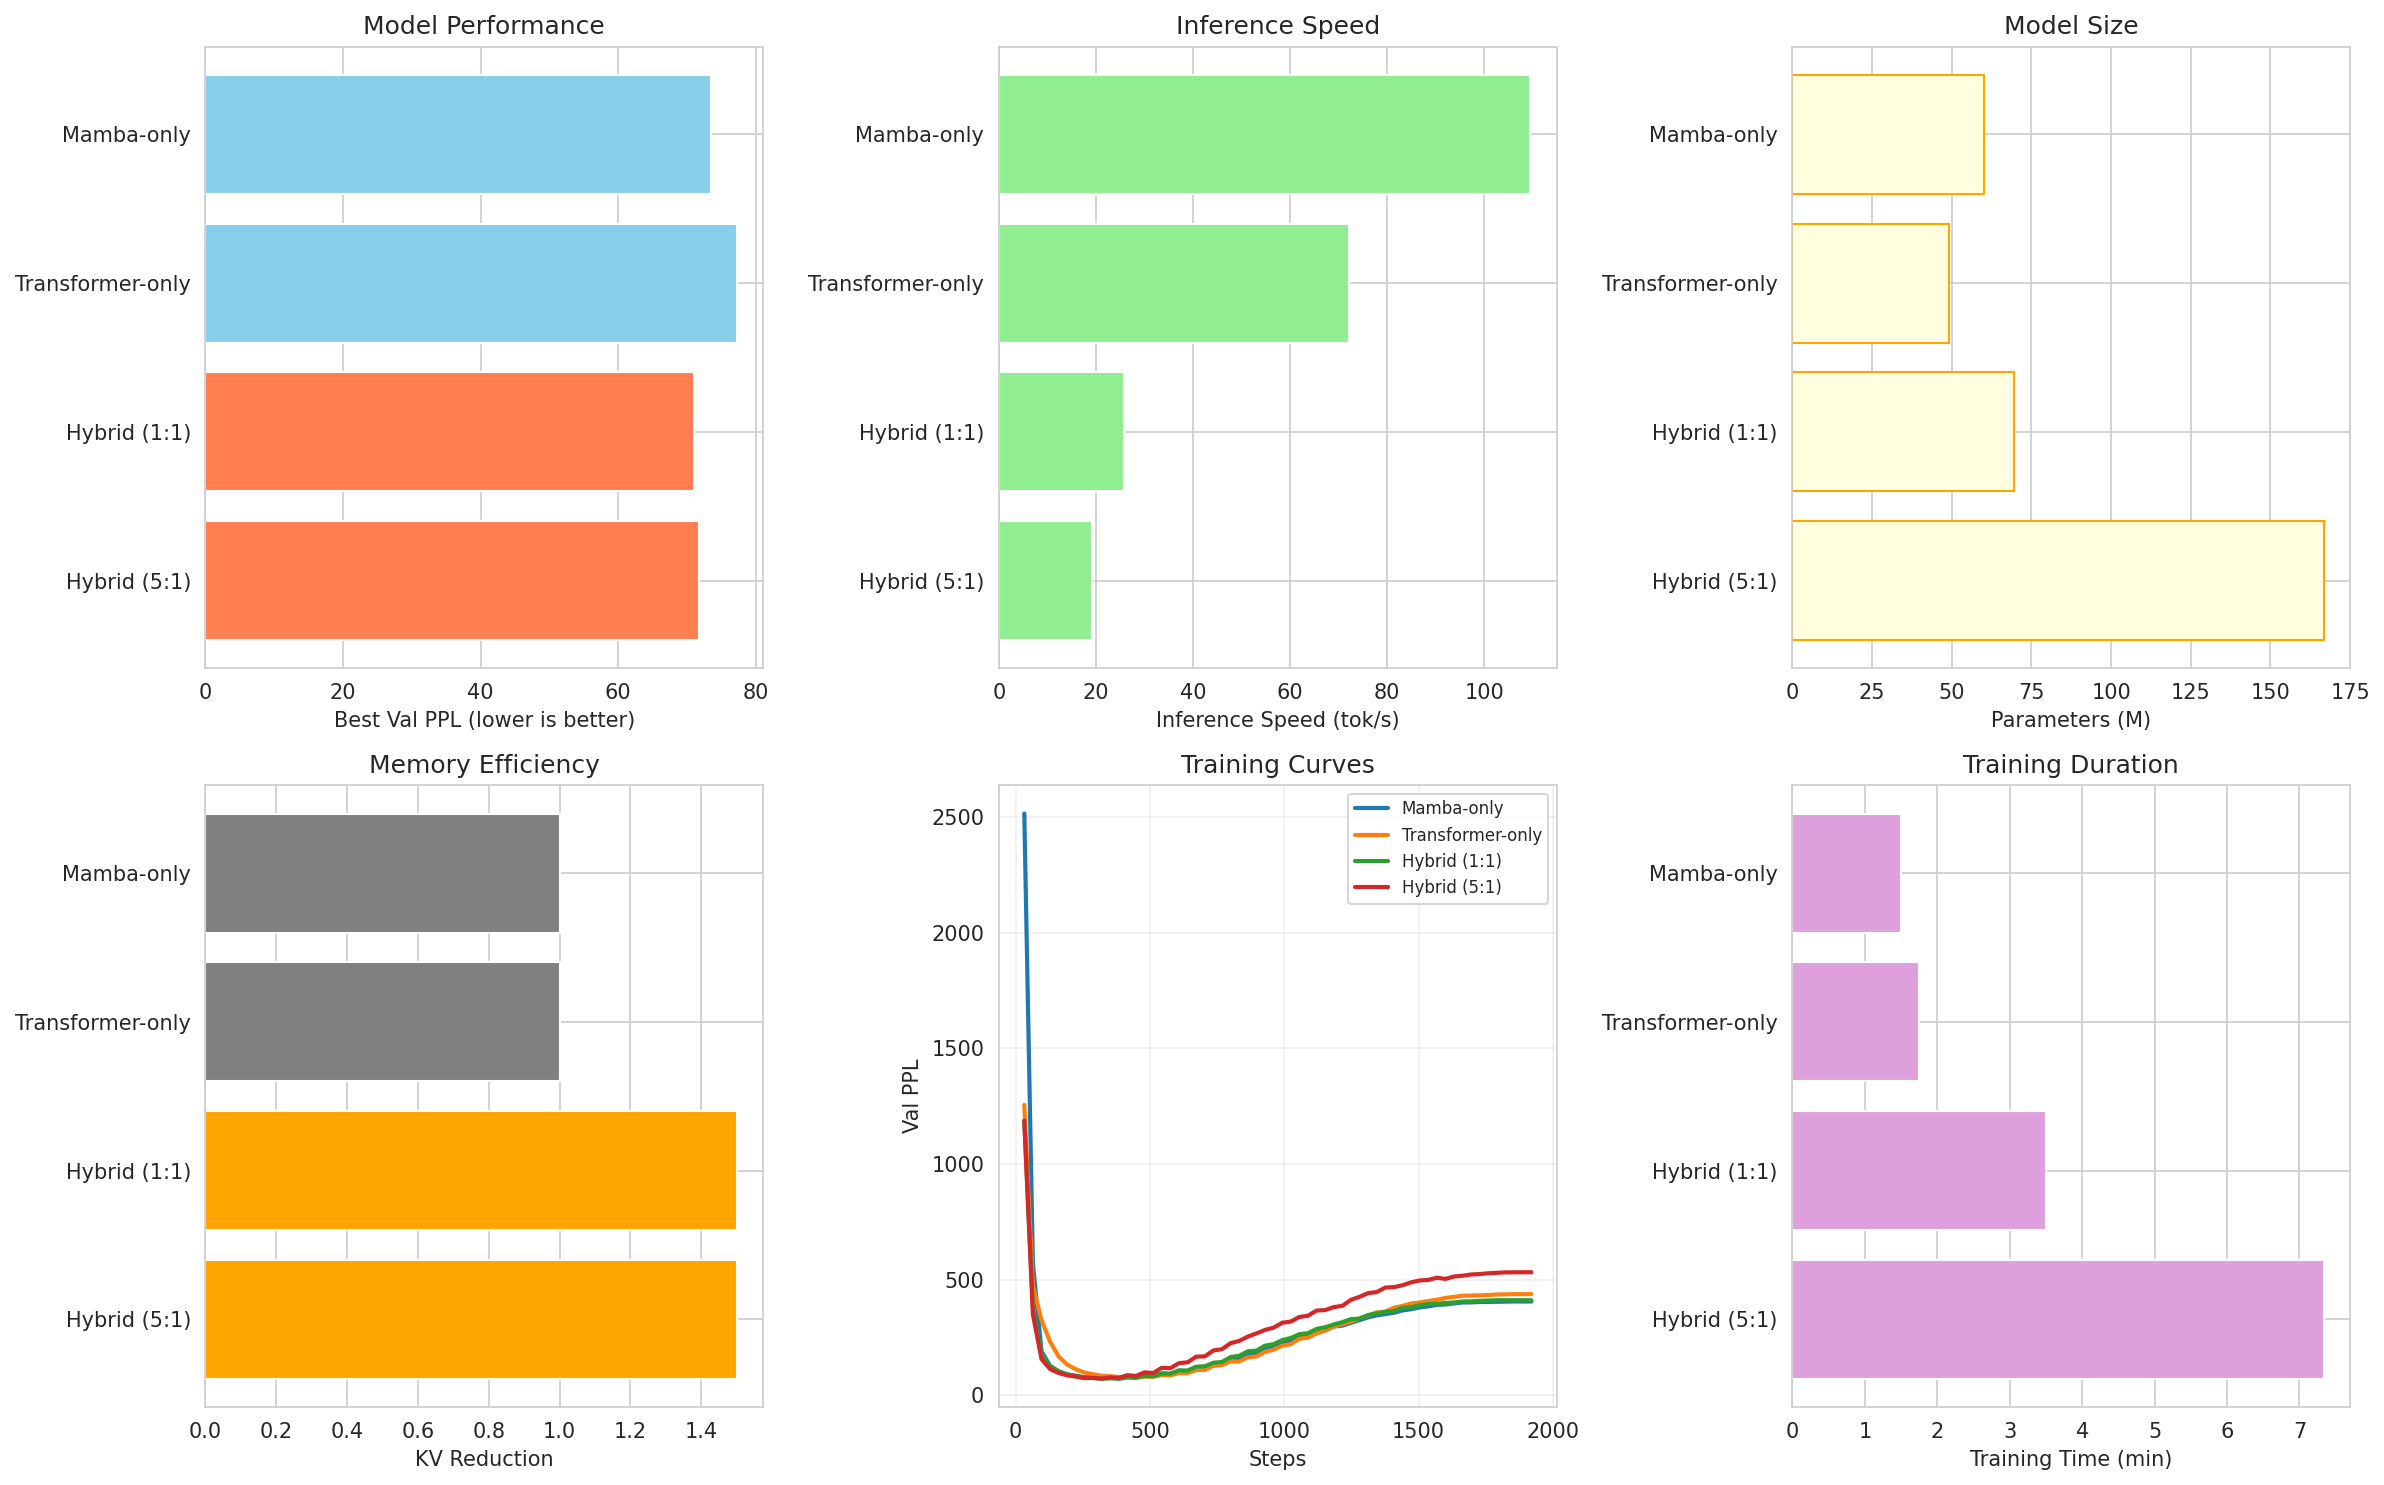

In [10]:
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

ax = axes[0, 0]
colors = ['coral' if 'Hybrid' in m else 'skyblue' for m in df['Model']]
ax.barh(df['Model'], df['Best PPL'], color=colors)
ax.set_xlabel('Best Val PPL (lower is better)')
ax.set_title('Model Performance')
ax.invert_yaxis()

ax = axes[0, 1]
ax.barh(df['Model'], df['Infer TPS'], color='lightgreen')
ax.set_xlabel('Inference Speed (tok/s)')
ax.set_title('Inference Speed')
ax.invert_yaxis()

ax = axes[0, 2]
ax.barh(df['Model'], df['Params (M)'], color='lightyellow', edgecolor='orange')
ax.set_xlabel('Parameters (M)')
ax.set_title('Model Size')
ax.invert_yaxis()

ax = axes[1, 0]
kv_colors = ['gray' if x == 1.0 else 'orange' for x in df['KV Reduction']]
ax.barh(df['Model'], df['KV Reduction'], color=kv_colors)
ax.set_xlabel('KV Reduction')
ax.set_title('Memory Efficiency')
ax.invert_yaxis()

ax = axes[1, 1]
for name, r in results.items():
    ax.plot(r['history']['step'], r['history']['val_ppl'], label=name, linewidth=2)
ax.set_xlabel('Steps')
ax.set_ylabel('Val PPL')
ax.set_title('Training Curves')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

ax = axes[1, 2]
ax.barh(df['Model'], df['Time (min)'], color='plum')
ax.set_xlabel('Training Time (min)')
ax.set_title('Training Duration')
ax.invert_yaxis()

plt.tight_layout()
plt.savefig(f'{RESULTS_DIR}/ablation_results.png', dpi=300, bbox_inches='tight')
plt.show()

## 7. 생성 품질

In [11]:
prompts = ['ROMEO:', 'First Citizen:', 'KING:']
for i, prompt in enumerate(prompts):
    print(f"\n{'='*60}\nPrompt: {prompt}\n{'='*60}")
    for name, r in results.items():
        print(f'\n[{name}]')
        print(r['samples'][i])


Prompt: ROMEO:

[Mamba-only]
rome o : well , b in my wif e , a long er be low ly we wish ' s once again s t thy wif e scal us too m ost ill - t thy father ' d one , a live in a go a g aunt : no furthe s t ry b in a happ y ; and do meet . gloucester : what i ' d one , but i am i must be yond cloud s

[Transformer-only]
rome o : well , will you ? rome o ' tis a hol y e ' s : i , makes t hat h it is she is she hat h it is too , she is she keep you : she die . mercu tio ' s are man ' s uch self , ' s art too ? rome o ' s ! she move s ever ' s ! she speak s uch a maid , she hat h

[Hybrid (1:1)]
rome o : well - fall out of his bod y ears , when the air ; for some thing s uch sur name of his tongue s o ' s lain , when the strong and thine ear to their hearts toge ther to him self same tongue less labour to a match not e ither part ly , when the air ; for your self same sun , in my self to him self same tongue more than my self abroa

[Hybrid (5:1)]
rome o : well - advised me lanch o ' s uch

## 8. 결론

In [12]:
print('='*60)
print('Key Findings')
print('='*60)

best_ppl = df.loc[df['Best PPL'].idxmin()]
print(f'1. Best Performance: {best_ppl["Model"]} (PPL: {best_ppl["Best PPL"]:.2f})')

best_infer = df.loc[df['Infer TPS'].idxmax()]
print(f'2. Fastest Inference: {best_infer["Model"]} ({best_infer["Infer TPS"]:.1f} tok/s)')

best_kv = df.loc[df['KV Reduction'].idxmax()]
print(f'3. Best Memory Efficiency: {best_kv["Model"]} ({best_kv["KV Reduction"]:.2f}x)')

print('\nConclusions:')
print('- Mamba-only: Fastest inference, no KV cache')
print('- Transformer-only: Stable performance, high memory')
print('- Hybrid: Balance of performance and efficiency')

Key Findings
1. Best Performance: Hybrid (1:1) (PPL: 71.01)
2. Fastest Inference: Mamba-only (109.4 tok/s)
3. Best Memory Efficiency: Hybrid (1:1) (1.50x)

Conclusions:
- Mamba-only: Fastest inference, no KV cache
- Transformer-only: Stable performance, high memory
- Hybrid: Balance of performance and efficiency


## 9. 결과 저장

In [13]:
df.to_csv(f'{RESULTS_DIR}/ablation_results.csv', index=False)
print(f'Saved: {RESULTS_DIR}/ablation_results.csv')

with open(f'{RESULTS_DIR}/generation_samples.txt', 'w') as f:
    for i, prompt in enumerate(['ROMEO:', 'First Citizen:', 'KING:']):
        f.write(f'Prompt: {prompt}\n')
        for name, r in results.items():
            f.write(f'[{name}]\n{r["samples"][i]}\n\n')
print(f'Saved: {RESULTS_DIR}/generation_samples.txt')

Saved: ./results/ablation_results.csv
Saved: ./results/generation_samples.txt
